In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [17]:
def read_prediction_file(file_path):
    try:
        df = pd.read_csv(file_path)
        # verify that the file at least has "True Values" and "Predictions" value columns
        if not "True Values" in df.columns or not "Predictions" in df.columns:
            print(df.columns)
            raise Exception("Archivo no contiene columnas de valores reales y predicciones.")
            
        # verify that the file has at least one row
        if df.shape[0] < 1:
            raise Exception("Archivo de pronostico no contiene datos.")
        # verify that the file has the same number of rows in both columns
        if df["True Values"].shape[0] != df["Predictions"].shape[0]:
            raise Exception("Número de filas de valores reales y predicciones no coinciden.")
    except Exception as e:
        print("ERROR: no se completó la lectura de archivo de pronósticos. {}".format(e))
        return None
    return df

In [18]:
df = read_prediction_file("./input/strat_v1.csv")
df

,Date,LMCADS03,DXY,COMXCOPR,SPX,BCOM,MXWD,CL1,XAU,XAG,LMCADY RETURN,True Values,LMCADY,Predictions,PREDICTED PRICE,ACTUAL FUTURE PRICE,ERROR,ERROR%,XPCD_CHG,ACT_CHG
0,3/27/2023,8964.0,102.86,15400,3977.53,103.7487,626.52,72.81,1956.67,23.0810,0.004423,-0.003834,8951.25,0.002039,8969.515820,9003.50,33.9842,0.003775,18.27,52.25
1,3/28/2023,8978.0,102.43,15624,3971.27,104.3620,627.48,73.20,1973.54,23.3340,0.001897,-0.025752,8968.25,0.003347,8998.317366,8917.00,81.3174,0.009119,30.07,-51.25
2,3/29/2023,9002.5,102.64,16027,4027.81,104.1591,635.30,72.97,1964.70,23.3350,0.004506,-0.025179,9008.75,0.002670,9032.835757,8740.25,292.5858,0.033476,24.09,-268.50
3,3/30/2023,9001.0,102.14,16278,4050.83,104.3921,639.89,74.37,1980.37,23.9030,-0.000611,-0.022067,9003.25,0.000124,9004.369197,8784.75,219.6192,0.025000,1.12,-218.50
4,3/31/2023,8993.0,102.51,16543,4109.31,105.5076,646.76,75.67,1969.28,24.0990,0.000028,-0.022095,9003.50,-0.000574,8998.337436,8806.75,191.5874,0.021755,-5.16,-196.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,4/8/2024,9411.5,104.14,29505,5202.39,102.9183,778.04,86.43,2339.03,27.8505,0.007897,0.023212,9281.51,0.001946,9299.591504,9333.20,33.6085,0.003601,18.08,51.69
271,4/9/2024,9417.5,104.15,29607,5209.91,102.8042,779.23,85.23,2352.78,28.1520,0.000161,0.007737,9283.00,0.008118,9358.664395,9499.47,9358.6644,0.014822,75.66,-9283.00
272,4/10/2024,9374.0,105.25,29285,5160.64,102.8709,772.78,86.21,2334.04,27.9481,-0.004594,0.026616,9240.45,0.015452,9384.342986,9355.10,9384.3430,0.003126,143.89,-9240.45
273,4/11/2024,9342.0,105.28,29173,5199.06,102.3493,774.88,85.02,2372.52,28.4437,-0.003312,0.046886,9209.90,0.017096,9368.708080,9489.70,9368.7081,0.012750,158.81,-9209.90


In [19]:
df['op'] = ""

In [20]:
# calculate true values std deviation
true_values_std = df["True Values"].std()
print("Test std: {:.6f}".format(true_values_std))

Test std: 0.022042


In [21]:
# calculate rmse using true values and predictions
def calculate_rmse(true_values, predictions):
    return np.sqrt(np.mean((true_values - predictions)**2))

rmse = calculate_rmse(df["True Values"], df["Predictions"])
print("RMSE: {:.6f}".format(rmse))

RMSE: 0.021314


In [26]:
def plot_predictions(y_true, y_pred, n=-1, title="Prediction vs Actual Data", markersize=3, rmse=None, df = None, mt = 1):
    if n != -1:
        n = min(n, len(y_true), len(y_pred))

        y_true = y_true[-n:]
        y_pred = y_pred[-n:]

    plt.figure(figsize=(18, 2.5))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)

    prof_acum = 0.0

    # Plot the RMSE lines if rmse is provided
    if rmse is not None:
        plt.axhline(y= rmse, color='green', linestyle='--', linewidth=0.7)
        plt.axhline(y=-rmse, color='green', linestyle='--', linewidth=0.7)

        tot_pred = 0
        prof = 0
        loss = 0

        j = 0

        # plot green markers beyond the rmse range
        for i in range(len(y_pred)):
            if (y_pred[i] > rmse or y_pred[i] < - rmse): # situacion
                # print("{} {}".format(y_pred[i],y_true[i]))
                print("{}) {} - Variación significativa {:.4f}.".format(j+1,df['Date'][i],y_pred[i]))
                # print("Precio pactado por Tn métrica: {:,.2f}".format(df['LMCADY'][i]))
                

                if (y_true[i] > 0 and y_pred[i] > 0) or (y_true[i] < 0 and y_pred[i] < 0):
                    plt.plot(i, y_pred[i], 'gx', markersize=markersize+1)
                    
                    if (y_true[i] > 0 and y_pred[i] > 0):
                        print("Precio de COMPRA acordado    : {:,.2f}".format(df['LMCADY'][i]))
                        prof_op = (-df['LMCADY'][i]+df['ACTUAL FUTURE PRICE'][i])*mt
                        df.loc[i, "col"] = 'BUY'
                    if (y_true[i] < 0 and y_pred[i] < 0):
                        print("Precio de VENTA acordado     : {:,.2f}".format(df['LMCADY'][i]))
                        prof_op = (+df['LMCADY'][i]-df['ACTUAL FUTURE PRICE'][i])*mt
                        df.loc[i, "col"] = 'SELL'
                        # df['op'][i] = 'SLL'

                    prof += 1
                else:
                    plt.plot(i, y_pred[i], 'rx', markersize=markersize+1)
                    loss += 1

                print("Precio futuro pronosticado   : {:,.2f}".format(df['PREDICTED PRICE'][i]))
                print("Precio futuro real           : {:,.2f}".format(df['ACTUAL FUTURE PRICE'][i]))
                print("Diferencia por operación     : {:,.2f}".format(prof_op))
                prof_acum += prof_op
                print("Ganancia acumulada: {:,.2f}".format(prof_acum))
                tot_pred += 1
                j += 1
                print("")
            else:
                plt.plot(i, y_pred[i], marker='x', color='orange', markersize=markersize-1)
            

    else:
        plt.plot(y_true, label='Actual Values'   , marker='o', linestyle='-' , markersize=markersize)
        plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    print("FINAL ACUM. PROFIT: {:,.2f}".format(prof_acum))
    

    return tot_pred, prof, loss

1) 4/13/2023 - Variación significativa -0.0121.
Precio de VENTA acordado     : 9,065.75
Precio futuro pronosticado   : 8,957.02
Precio futuro real           : 8,947.75
Diferencia por operación     : 354.00
Ganancia acumulada: 354.00

2) 4/14/2023 - Variación significativa -0.0194.
Precio de VENTA acordado     : 9,030.25
Precio futuro pronosticado   : 8,857.03
Precio futuro real           : 8,865.25
Diferencia por operación     : 495.00
Ganancia acumulada: 849.00

3) 4/17/2023 - Variación significativa -0.0145.
Precio de VENTA acordado     : 8,962.95
Precio futuro pronosticado   : 8,834.17
Precio futuro real           : 8,778.50
Diferencia por operación     : 553.35
Ganancia acumulada: 1,402.35

4) 4/18/2023 - Variación significativa -0.0132.
Precio de VENTA acordado     : 9,004.40
Precio futuro pronosticado   : 8,886.30
Precio futuro real           : 8,710.00
Diferencia por operación     : 883.20
Ganancia acumulada: 2,285.55

5) 4/19/2023 - Variación significativa -0.0143.
Precio de VE

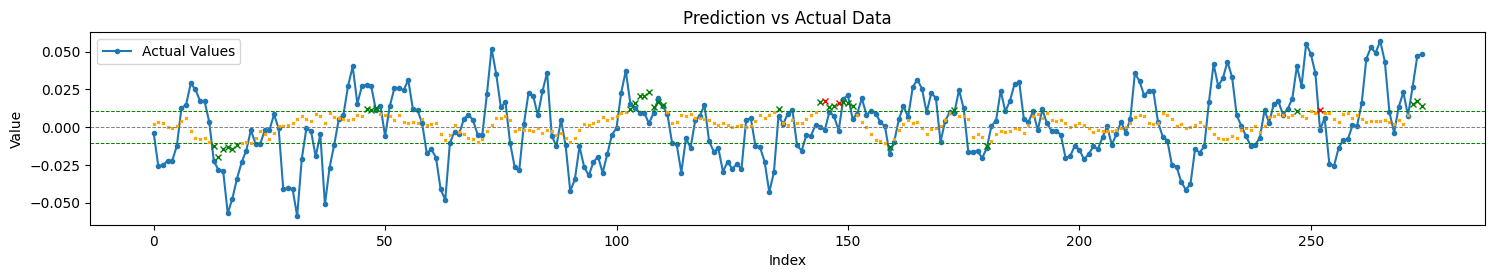

FINAL ACUM. PROFIT: 12,782.46
Total de predicciones:       34
Predicciones correctas:      31
Predicciones incorrectas:    3


In [27]:
tot_pred, prof, loss = plot_predictions(df['True Values'], df['Predictions'], n=-1, title='Prediction vs Actual Data', markersize=3, rmse=rmse*0.5, df = df, mt = 3)
print("Total de predicciones:       {}".format(tot_pred))
print("Predicciones correctas:      {}".format(prof))
print("Predicciones incorrectas:    {}".format(loss))

In [37]:
# plot df['LMCADY'] using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['LMCADY'], mode='lines', name='Precio LMCADY'))
# add a point marker for the rows where ['op'] is not ""
fig.add_trace(go.Scatter(x=df['Date'][df['op'] == 'BUY'], y=df['LMCADY'][df['op'] == 'BUY'], mode='markers', marker=dict(color='green'  , size=10), name='BUY'))
fig.add_trace(go.Scatter(x=df['Date'][df['op'] == 'SLL'], y=df['LMCADY'][df['op'] == 'SLL'], mode='markers', marker=dict(color='red'    , size=10), name='SLL'))

# modify marker size
fig.update_traces(marker=dict(size=5))

fig.update_layout(title='Precio LMCADY', xaxis_title='Fecha', yaxis_title='Precio LMCADY')
# make x axis readable and not so frequent
fig.update_xaxes(tickangle=45, tickmode='linear', dtick=5)
fig.show()
